# Clasificación de Fallas en Fresadora

En este notebook vamos a explorar un dataset que contiene registros de fresadoras, pero dado que no tenemos registros de tiempos, no nos vamos a concentrar en clasificar las fallas, para que una vez ocurridas las mismas, poder usar una serie de pasos lógicos para encontrar el problema más probable.

Tenemos las fallas clasificadas en cinco categorías:
- Desgaste o falla de la herramienta
- Problemas con disipación de calor
- Problemas de potencia
- Sobreesfuerzo
- Random

---

## Dataset

#### Este Dataset contiene 10mil lecturas de 14 variables

1. **UID:** Identificador único (unique identifier ranging) from 1 to 10000

2. **Product ID:** letra L (low, 50% de los productos), M (medium 30%) y H (high 20%) que representan la calidad del producto según las tolerancias requeridas, seguido de un número de serie del producto.

3. **Type:** Tipo de producto explicado en columna anterior.

4. **Air temperature [K]:** Generado mediante un proceso de random walk luego normalizado a una desviación estándar de 2 K alrededor de 300 K

5. **Process temperature [K]:** Generado mediante un proceso de random walk normalizado a una desviación estándar de 1 K, sumado a la temperatura del aire más 10 K.

6. **Rotational speed [rpm]:** Calculada a partir de una potencia de 2860 W, superpuesta con un ruido distribuido normalmente.

7. **Torque [Nm]:** Los valores del par se distribuyen normalmente en torno a 40 Nm con una desviación estandard SD = 10 Nm y sin valores negativos.

8. **Tool wear [min]:** Las variantes de calidad H/M/L añaden 5/3/2 minutos de desgaste de herramienta a la herramienta usada en el proceso.

9. **Machine failure:** Indica una falla de la fresadora.

**La falla de la fresadora puede estar catalogada dentro de las siguientes columnas:**

10. **TWF (Tool wear failure):** La herramienta se reemplazará o fallará en un tiempo de desgaste de la herramienta seleccionado al azar entre 200 y 240 minutos (120 veces en nuestro conjunto de datos). En este momento, la herramienta se reemplaza 69 veces y falla 51 veces.

11. **HDF (Heat dissipation failure):** La disipación de calor provoca un fallo del proceso si la diferencia entre la temperatura del aire y del proceso es inferior a 8,6 K y la velocidad de rotación de las herramientas es inferior a 1380 rpm. Este es el caso de 115 puntos de datos.

12. **PWF (power failure):** El producto del par y la velocidad de rotación (en rad/s) es igual a la potencia requerida para el proceso. Si esta potencia es inferior a 3500 W o superior a 9000 W, el proceso falla, como ocurre 95 veces en nuestro conjunto de datos.

13. **OSF (Overstrain failure):** Si el producto del desgaste de la herramienta y el par excede los 11.000 minNm para la variante de producto L (12.000 M, 13.000 H), el proceso falla debido al sobreesfuerzo. Esto es cierto para 98 puntos de datos.

14. **RNF (Random failures):** Cada proceso tiene una probabilidad del 0,1 % de fallar independientemente de sus parámetros de proceso. Este es el caso de sólo 5 puntos de datos, menos de lo que se podría esperar de 10.000 puntos de datos en nuestro conjunto de datos.

---

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [103]:
df = pd.read_csv('ai4i2020.csv')
df.drop(["UDI", "Product ID"], axis=1, inplace=True)

In [104]:
df_inicial.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


Nos vamos a preocupar solamente por las fallas, por lo que vamos a eliminar todas las filas en las que no se presentan fallas.

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Machine failure          10000 non-null  int64  
 7   TWF                      10000 non-null  int64  
 8   HDF                      10000 non-null  int64  
 9   PWF                      10000 non-null  int64  
 10  OSF                      10000 non-null  int64  
 11  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 937.6+ KB


In [106]:
twf = df["TWF"].sum()
hdf = df["HDF"].sum()
pwf = df["PWF"].sum()
osf = df["OSF"].sum()
rnf = df["RNF"].sum()
mf = df["Machine failure"].sum()

print(f"TWF = {twf}")
print(f"HDF = {hdf}")
print(f"PWF = {pwf}")
print(f"OSF = {osf}")
print(f"RNF = {rnf}")
print(f"Total = {twf + hdf + pwf + osf + rnf}")
print(f"MF = {mf}")

TWF = 46
HDF = 115
PWF = 95
OSF = 98
RNF = 19
Total = 373
MF = 339


In [107]:
df["fallas"] = df["TWF"] + df["HDF"] + df["PWF"] + df["OSF"] + df["RNF"]
df[df["fallas"] > 0]

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,fallas
50,L,298.9,309.1,2861,4.6,143,1,0,0,1,0,0,1
69,L,298.9,309.0,1410,65.7,191,1,0,0,1,1,0,2
77,L,298.8,308.9,1455,41.3,208,1,1,0,0,0,0,1
160,L,298.4,308.2,1282,60.7,216,1,0,0,0,1,0,1
161,L,298.3,308.1,1412,52.3,218,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9758,L,298.6,309.8,2271,16.2,218,1,1,0,0,0,0,1
9764,L,298.5,309.5,1294,66.7,12,1,0,0,1,0,0,1
9822,L,298.5,309.4,1360,60.9,187,1,0,0,0,1,0,1
9830,L,298.3,309.3,1337,56.1,206,1,0,0,0,1,0,1


In [108]:
mask = (df["TWF"] == 1) | (df["HDF"] == 1) | (df["PWF"] == 1) | (df["OSF"] == 1) | (df["RNF"] == 1)

df_fallas_comb = df[mask]

len(df_fallas_comb)

348

In [109]:
df_m_f = df[df["Machine failure"] == 1]
len(df_m_f)

339

Vemos una diferencia en la cantidad total de fallas con respecto a las clasificadas como `Machine failure`.

In [110]:
df_fallas_comb[df_fallas_comb["Machine failure"] == 0]

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,fallas
1221,M,297.0,308.3,1399,46.4,132,0,0,0,0,0,1,1
1302,L,298.6,309.8,1505,45.7,144,0,0,0,0,0,1,1
1748,H,298.4,307.7,1626,31.1,166,0,0,0,0,0,1,1
2072,L,299.6,309.5,1570,35.5,189,0,0,0,0,0,1,1
2559,L,299.3,309.0,1447,50.4,140,0,0,0,0,0,1,1
3065,M,300.1,309.2,1687,27.7,95,0,0,0,0,0,1,1
3452,H,301.6,310.5,1602,32.3,2,0,0,0,0,0,1,1
5471,L,302.7,312.3,1346,61.2,170,0,0,0,0,0,1,1
5489,L,302.6,312.1,1499,35.0,215,0,0,0,0,0,1,1
5495,H,302.9,312.5,1357,55.0,12,0,0,0,0,0,1,1


In [111]:
df_m_f[df_m_f["fallas"] == 0]

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,fallas
1437,H,298.8,309.9,1439,45.2,40,1,0,0,0,0,0,0
2749,M,299.7,309.2,1685,28.9,179,1,0,0,0,0,0,0
4044,M,301.9,310.9,1419,47.7,20,1,0,0,0,0,0,0
4684,M,303.6,311.8,1421,44.8,101,1,0,0,0,0,0,0
5536,M,302.3,311.8,1363,54.0,119,1,0,0,0,0,0,0
5941,L,300.6,310.7,1438,48.5,78,1,0,0,0,0,0,0
6478,L,300.5,309.8,1663,29.1,145,1,0,0,0,0,0,0
8506,L,298.4,309.6,1710,27.3,163,1,0,0,0,0,0,0
9015,L,297.2,308.1,1431,49.7,210,1,0,0,0,0,0,0


In [112]:
df_fallas_comb[df_fallas_comb["fallas"] > 1]

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,fallas
69,L,298.9,309.0,1410,65.7,191,1,0,0,1,1,0,2
1324,M,298.8,310.1,1243,74.5,194,1,0,0,1,1,0,2
1496,L,298.0,308.7,1268,69.4,189,1,0,0,1,1,0,2
3611,L,301.7,310.9,1405,46.4,207,1,1,0,0,0,1,2
3854,L,302.4,311.0,1338,67.6,194,1,0,0,1,1,0,2
3943,L,302.3,311.4,1333,66.7,205,1,0,0,1,1,0,2
4254,L,302.6,311.0,1284,68.0,114,1,0,1,1,0,0,2
4342,M,301.7,309.8,1284,68.2,111,1,0,1,1,0,0,2
4370,L,302.0,309.9,1308,57.6,197,1,0,1,0,1,0,2
4383,L,301.7,309.5,1298,65.5,229,1,0,1,0,1,0,2


Despues de un intenso análisis podemos ver que en la columna `Machine failure` hay fallas etiquetadas como tales, pero que no poseen clasificación, así que vamos a seleccionar solo las que tienen clasificación.

Por otro lado también vemos que hay algunas repetidas, así que las vamos a clasificar según la que ocurre más seguido.

Orden de importancia:
1. HDF = 115
2. OSF = 98
3. PWF = 95
4. TWF = 46
5. RNF = 19

In [113]:
df = df_fallas_comb.copy()

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 348 entries, 50 to 9974
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     348 non-null    object 
 1   Air temperature [K]      348 non-null    float64
 2   Process temperature [K]  348 non-null    float64
 3   Rotational speed [rpm]   348 non-null    int64  
 4   Torque [Nm]              348 non-null    float64
 5   Tool wear [min]          348 non-null    int64  
 6   Machine failure          348 non-null    int64  
 7   TWF                      348 non-null    int64  
 8   HDF                      348 non-null    int64  
 9   PWF                      348 non-null    int64  
 10  OSF                      348 non-null    int64  
 11  RNF                      348 non-null    int64  
 12  fallas                   348 non-null    int64  
dtypes: float64(3), int64(9), object(1)
memory usage: 38.1+ KB


Generamos una sola columna con las fallas categorizadas y respetando las prioridades

In [115]:
df["HDF"] = df["HDF"].astype(str).replace("0", "").replace("1", "HDF")
df["OSF"] = df["OSF"].astype(str).replace("0", "").replace("1", "OSF")
df["PWF"] = df["PWF"].astype(str).replace("0", "").replace("1", "PWF")
df["TWF"] = df["TWF"].astype(str).replace("0", "").replace("1", "TWF")
df["RNF"] = df["RNF"].astype(str).replace("0", "").replace("1", "RNF")
df["failure"] = df["HDF"] + df["OSF"] + df["PWF"] + df["TWF"] + df["RNF"]
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,fallas,failure
50,L,298.9,309.1,2861,4.6,143,1,,,PWF,,,1,PWF
69,L,298.9,309.0,1410,65.7,191,1,,,PWF,OSF,,2,OSFPWF
77,L,298.8,308.9,1455,41.3,208,1,TWF,,,,,1,TWF
160,L,298.4,308.2,1282,60.7,216,1,,,,OSF,,1,OSF
161,L,298.3,308.1,1412,52.3,218,1,,,,OSF,,1,OSF


In [116]:
df["failure"] = df["failure"].apply(lambda x: x[:3])
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,fallas,failure
50,L,298.9,309.1,2861,4.6,143,1,,,PWF,,,1,PWF
69,L,298.9,309.0,1410,65.7,191,1,,,PWF,OSF,,2,OSF
77,L,298.8,308.9,1455,41.3,208,1,TWF,,,,,1,TWF
160,L,298.4,308.2,1282,60.7,216,1,,,,OSF,,1,OSF
161,L,298.3,308.1,1412,52.3,218,1,,,,OSF,,1,OSF


In [117]:
df.drop(["Machine failure", "TWF", "HDF", "PWF", "OSF", "RNF", "fallas"], axis=1, inplace=True)
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],failure
50,L,298.9,309.1,2861,4.6,143,PWF
69,L,298.9,309.0,1410,65.7,191,OSF
77,L,298.8,308.9,1455,41.3,208,TWF
160,L,298.4,308.2,1282,60.7,216,OSF
161,L,298.3,308.1,1412,52.3,218,OSF


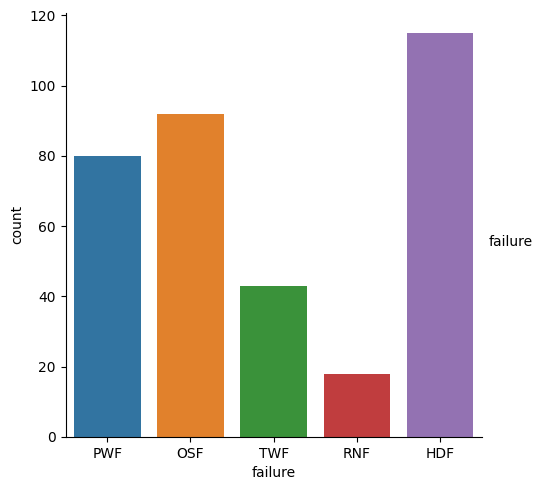

In [118]:
sns.catplot(data=df, x="failure", hue="failure", kind="count")